### Recommendation System

#### Content-based Filtering


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
from gensim import corpora, models, similarities
import re
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
STOP_WORD_FILE = 'data/vietnamese-stopwords.txt'

def getStopWords():
    stop_words = []
    with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
        stop_words = file.read()

    stop_words = stop_words.split('\n')
    return stop_words


In [4]:
stop_words = getStopWords()
stop_words

['a_lô',
 'a_ha',
 'ai',
 'ai_ai',
 'ai_nấy',
 'ai_đó',
 'alô',
 'amen',
 'anh',
 'anh_ấy',
 'ba',
 'ba_ba',
 'ba_bản',
 'ba_cùng',
 'ba_họ',
 'ba_ngày',
 'ba_ngôi',
 'ba_tăng',
 'bao_giờ',
 'bao_lâu',
 'bao_nhiêu',
 'bao_nả',
 'bay_biến',
 'biết',
 'biết_bao',
 'biết_bao_nhiêu',
 'biết_chắc',
 'biết_chừng_nào',
 'biết_mình',
 'biết_mấy',
 'biết_thế',
 'biết_trước',
 'biết_việc',
 'biết_đâu',
 'biết_đâu_chừng',
 'biết_đâu_đấy',
 'biết_được',
 'buổi',
 'buổi_làm',
 'buổi_mới',
 'buổi_ngày',
 'buổi_sớm',
 'bà',
 'bà_ấy',
 'bài',
 'bài_bác',
 'bài_bỏ',
 'bài_cái',
 'bác',
 'bán',
 'bán_cấp',
 'bán_dạ',
 'bán_thế',
 'bây_bẩy',
 'bây_chừ',
 'bây_giờ',
 'bây_nhiêu',
 'bèn',
 'béng',
 'bên',
 'bên_bị',
 'bên_có',
 'bên_cạnh',
 'bông',
 'bước',
 'bước_khỏi',
 'bước_tới',
 'bước_đi',
 'bạn',
 'bản',
 'bản_bộ',
 'bản_riêng',
 'bản_thân',
 'bản_ý',
 'bất_chợt',
 'bất_cứ',
 'bất_giác',
 'bất_kì',
 'bất_kể',
 'bất_kỳ',
 'bất_luận',
 'bất_ngờ',
 'bất_nhược',
 'bất_quá',
 'bất_quá_chỉ',
 'bất_thình_l

In [5]:
df = pd.read_csv("data/Products_ThoiTrangNam_raw.csv")
df.head()

,product_id,product_name,category,sub_category,link,image,price,rating,description
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-thun-g...,https://cf.shopee.vn/file/2c1ca03f5dc42f316fdf...,86250.0,4.9,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nÁo Ba ...
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Tr...,https://cf.shopee.vn/file/c7ea4c6574dc79be6b26...,26800.0,4.9,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nÁo Ba ...
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Ty...,https://cf.shopee.vn/file/6f93bcda10efe374f8cc...,39500.0,4.8,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nÁo Ba ...
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81O-BA-L%E1%BB%96-H%C3%8...,https://cf.shopee.vn/file/1d7ed5e34bff8bc8b49a...,16500.0,4.8,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nÁo Ba ...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Nam-Th%E1%BB%83...,NaN,45000.0,4.8,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nÁo Ba ...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49663 entries, 0 to 49662
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    49663 non-null  int64  
 1   product_name  49663 non-null  object 
 2   category      49663 non-null  object 
 3   sub_category  49663 non-null  object 
 4   link          49663 non-null  object 
 5   image         36443 non-null  object 
 6   price         49663 non-null  float64
 7   rating        49663 non-null  float64
 8   description   48700 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.4+ MB


**EDA**

In [7]:
#### Content-based Filtering
df.columns

Index(['product_id', 'product_name', 'category', 'sub_category', 'link',
       'image', 'price', 'rating', 'description'],
      dtype='object')

In [8]:
num_cols = ['price', 'rating']
cat_cols = ['product_id', 'product_name', 'category', 'sub_category', 'link',
       'image', 'description']
       
product = df

count    4.966300e+04
mean     2.336831e+05
std      9.853191e+05
min      0.000000e+00
25%      6.900000e+04
50%      1.419000e+05
75%      2.685710e+05
max      1.000000e+08
Name: price, dtype: float64


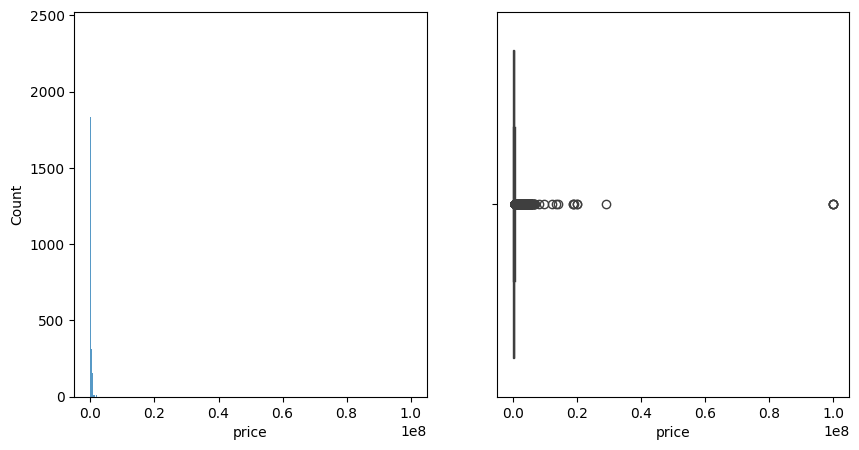

count    49663.00000
mean         3.08549
std          2.33958
min          0.00000
25%          0.00000
50%          4.80000
75%          5.00000
max          5.00000
Name: rating, dtype: float64


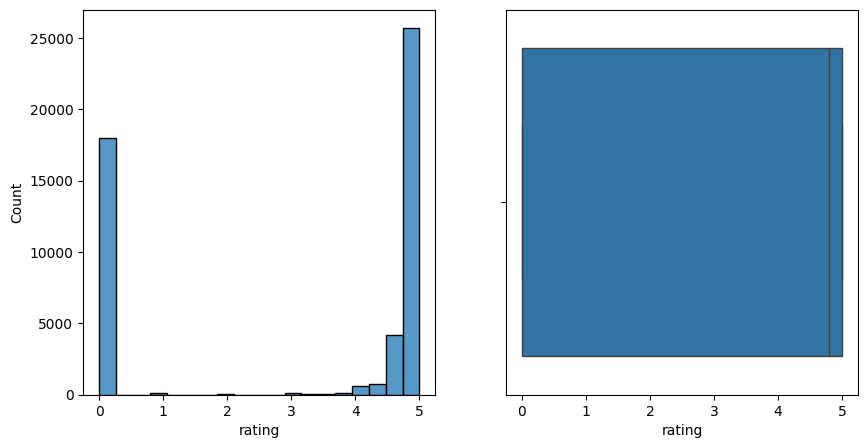

In [9]:
for col in num_cols:
    
    print(product[col].describe())
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.histplot(product, x = col)
    
    plt.subplot(1,2,2)
    sns.boxplot(product, x=col)
    
    plt.show()

In [10]:
for col in cat_cols:
    if product[col].nunique() < 20:
        print(col, product[col].nunique(), product[col].unique() )
    else:
        print(col, product[col].nunique())

product_id 49653
product_name 47103
category 1 ['Thời Trang Nam']
sub_category 17 ['Áo Ba Lỗ' 'Áo Hoodie, Áo Len & Áo Nỉ' 'Áo Khoác' 'Áo Vest và Blazer'
 'Áo' 'Cà vạt & Nơ cổ' 'Đồ Bộ' 'Đồ Hóa Trang' 'Đồ Lót' 'Đồ Ngủ' 'Khác'
 'Kính Mắt Nam' 'Quần Dài/Quần Âu' 'Quần Jeans' 'Quần Short'
 'Trang Phục Truyền Thống' 'Vớ/Tất']
link 49653
image 35191
description 45071


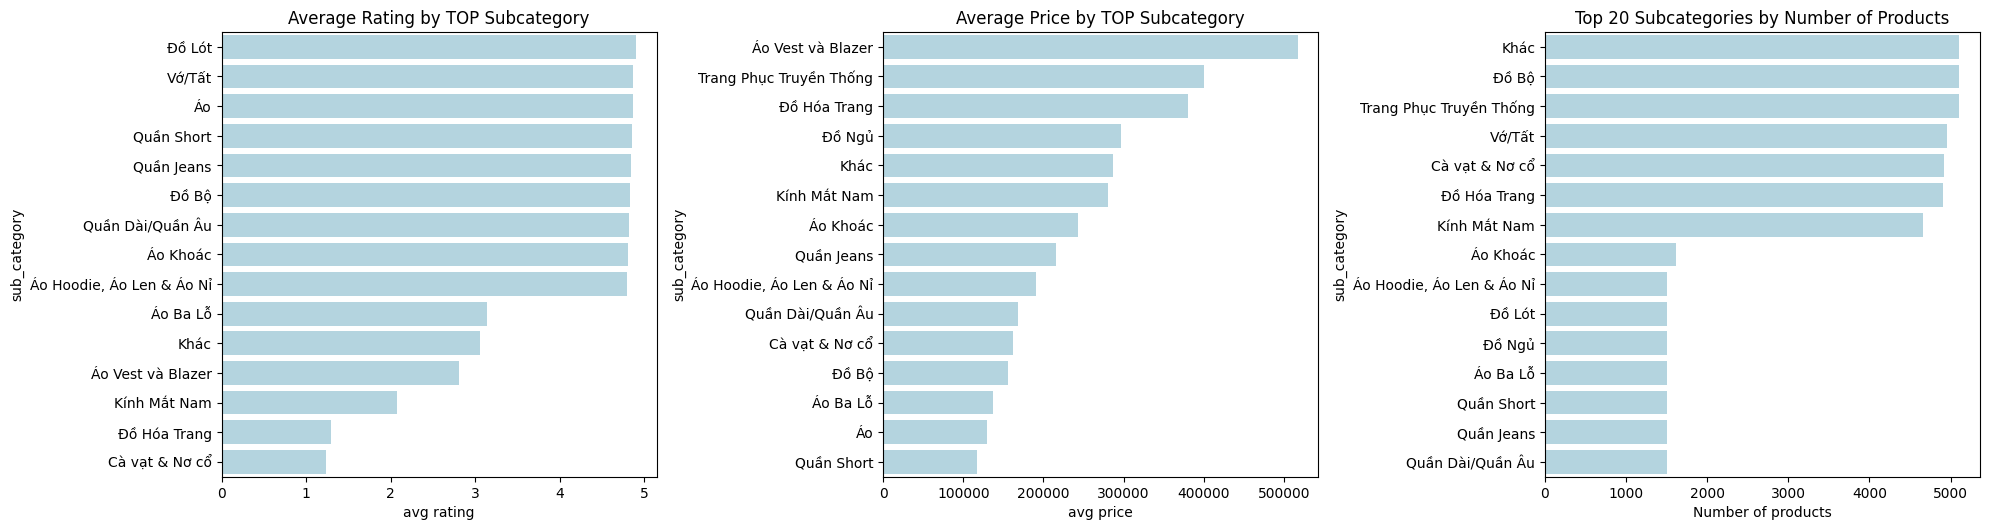

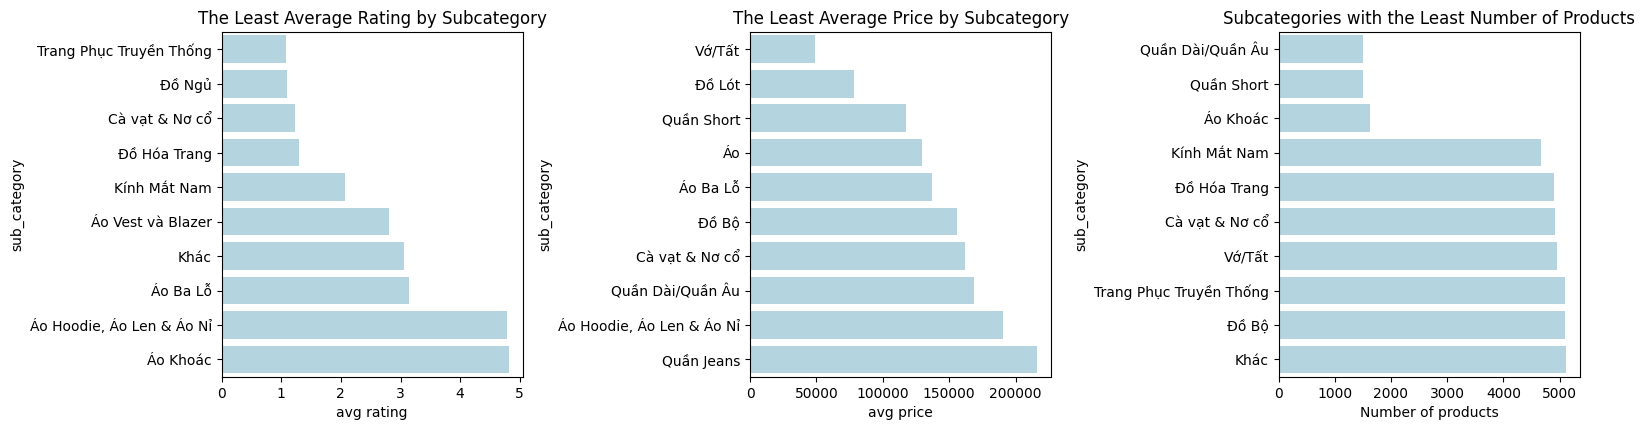

In [11]:
most_avg_rating = product.groupby('sub_category').agg(avg = ('rating', 'mean')).reset_index().sort_values(by = 'avg', ascending=False).head(15)
most_avg_price = product.groupby('sub_category').agg(avg = ('price', 'mean')).reset_index().sort_values(by = 'avg', ascending=False).head(15)
most_category = product.groupby('sub_category').agg(count = ('price', 'count')).reset_index().sort_values(by = 'count', ascending=False).head(15)

least_avg_rating = product.groupby('sub_category').agg(avg = ('rating', 'mean')).reset_index().sort_values(by = 'avg', ascending=True).head(10)
least_avg_price = product.groupby('sub_category').agg(avg = ('price', 'mean')).reset_index().sort_values(by = 'avg', ascending=True).head(10)
least_category = product.groupby('sub_category').agg(count = ('price', 'count')).reset_index().sort_values(by = 'count', ascending=True).tail(10)


plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
sns.barplot(most_avg_rating, x = 'avg', y = 'sub_category', color = 'lightblue')
plt.xlabel("avg rating")
plt.ylabel("sub_category")
plt.title('Average Rating by TOP Subcategory')

plt.subplot(2,3,2)
sns.barplot(most_avg_price, x = 'avg', y = 'sub_category', color = 'lightblue')
plt.xlabel("avg price")
plt.ylabel("sub_category")
plt.title('Average Price by TOP Subcategory')

plt.subplot(2,3,3)
sns.barplot(most_category, x = 'count', y = 'sub_category', color = 'lightblue')
plt.xlabel("Number of products")
plt.ylabel("sub_category")
plt.title('Top 20 Subcategories by Number of Products')

plt.tight_layout()

plt.figure(figsize=(16,8))
plt.subplot(2,3,4)
sns.barplot(least_avg_rating, x = 'avg', y = 'sub_category', color = 'lightblue')
plt.xlabel("avg rating")
plt.ylabel("sub_category")
plt.title('The Least Average Rating by Subcategory')

plt.subplot(2,3,5)
sns.barplot(least_avg_price, x = 'avg', y = 'sub_category', color = 'lightblue')
plt.xlabel("avg price")
plt.ylabel("sub_category")
plt.title('The Least Average Price by Subcategory')

plt.subplot(2,3,6)
sns.barplot(least_category, x = 'count', y = 'sub_category', color = 'lightblue')
plt.xlabel("Number of products")
plt.ylabel("sub_category")
plt.title('Subcategories with the Least Number of Products')

plt.tight_layout()
plt.show()

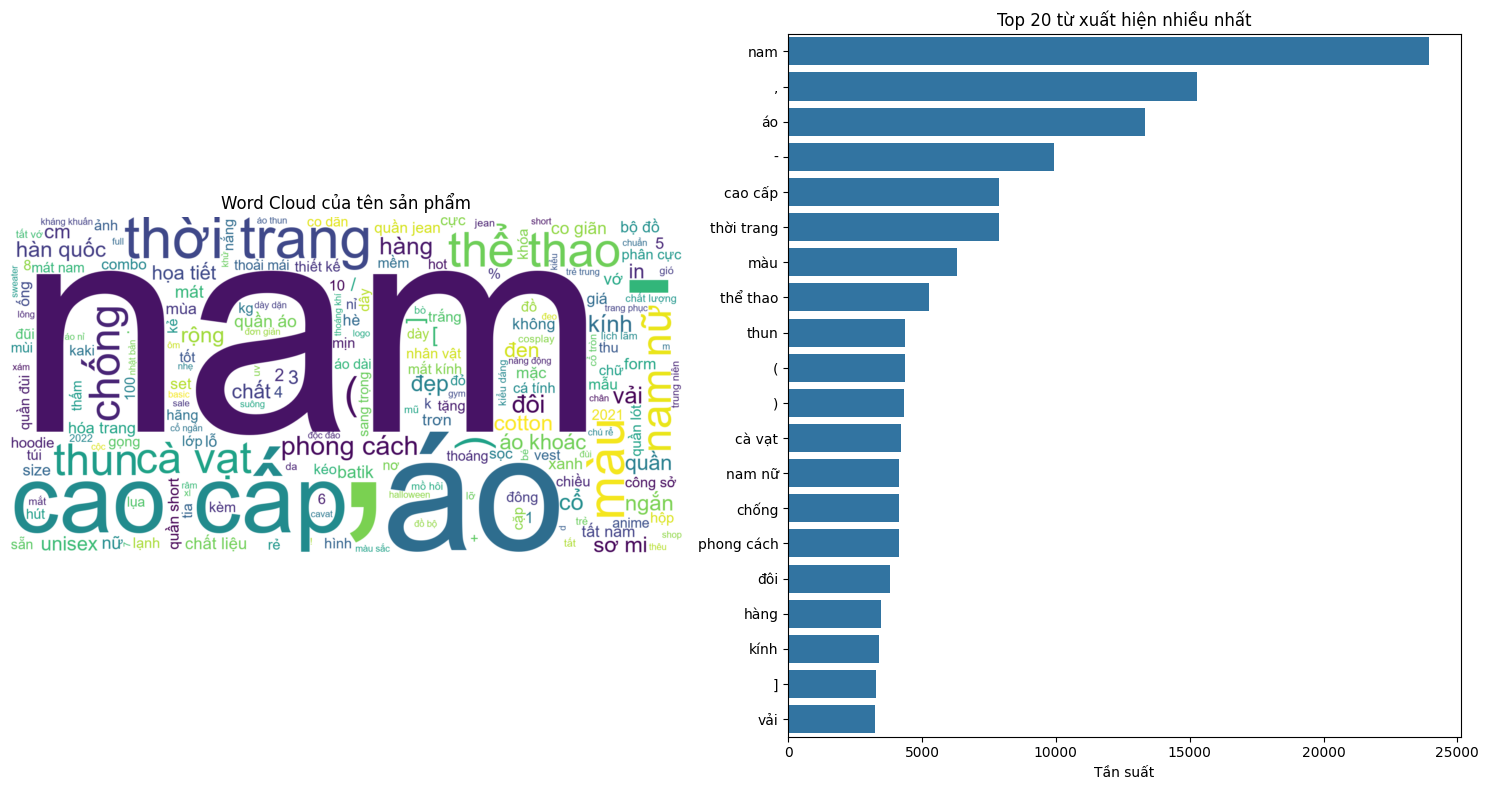


Top 20 từ xuất hiện nhiều nhất:
nam: 23937
,: 15280
áo: 13336
-: 9932
cao cấp: 7886
thời trang: 7859
màu: 6323
thể thao: 5246
thun: 4348
(: 4347
): 4342
cà vạt: 4228
nam nữ: 4142
chống: 4131
phong cách: 4124
đôi: 3788
hàng: 3471
kính: 3382
]: 3277
vải: 3248


In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from underthesea import word_tokenize
import seaborn as sns

def visualize_word_frequency(df):
    # Kết hợp tất cả text từ product_name
    text = ' '.join(df['product_name'].astype(str))
    
    # Tokenize từ tiếng Việt
    words = word_tokenize(text.lower())
    
    # Loại bỏ stopwords
    words = [w for w in words if w not in stop_words]
    
    # Đếm tần suất
    word_freq = Counter(words)
    
    # 1. Vẽ WordCloud
    plt.figure(figsize=(15, 8))
    wordcloud = WordCloud(width=1600, height=800,
                         background_color='white',
                         font_path='arial.ttf',  # Font hỗ trợ tiếng Việt
                         min_font_size=10).generate_from_frequencies(word_freq)
    
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud của tên sản phẩm')
    
    # 2. Vẽ biểu đồ top 20 từ phổ biến nhất
    plt.subplot(1, 2, 2)
    top_words = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20])
    
    sns.barplot(x=list(top_words.values()), y=list(top_words.keys()))
    plt.title('Top 20 từ xuất hiện nhiều nhất')
    plt.xlabel('Tần suất')
    
    plt.tight_layout()
    plt.show()

    # In ra số liệu thống kê
    print("\nTop 20 từ xuất hiện nhiều nhất:")
    for word, freq in top_words.items():
        print(f"{word}: {freq}")

# Gọi hàm để visualize
visualize_word_frequency(df)

**Clean Data**

* Kiểm tra tính hợp lệ của URLs

In [ ]:
import re

def is_valid_url(url):
    url_pattern = re.compile(
        r'^https?://'  # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+[A-Z]{2,6}\.?|'  # domain...
        r'localhost|'  # localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})'  # ...or ip
        r'(?::\d+)?'  # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)
    return bool(url_pattern.match(url))

def validate_urls(df):
    # Find invalid URLs
    invalid_mask = ~df['link'].apply(is_valid_url)
    invalid_links = df[invalid_mask]
    
    print("\nInvalid URLs count:", len(invalid_links))
    
    if len(invalid_links) > 0:
        # Log invalid URLs for review
        print("Invalid URLs found:")
        for idx, row in invalid_links.iterrows():
            print(f"Product ID {row['product_id']}: {row['link']}")
        
        # Remove rows with invalid URLs
        df_cleaned = df[~invalid_mask].copy()
        return df_cleaned
    
    return df

# Usage
df = validate_urls(df)


Invalid URLs count: 0


* Kiểm tra tính hợp lệ của Price, Ratings

In [ ]:
def validate_prices(df):
    negative_prices = (df['price'] < 0).sum()
    print(f"\nNegative prices: {negative_prices}")
    
    # Remove negative prices
    df_clean = df[df['price'] >= 0]
    
    return df_clean

def validate_ratings(df):
    invalid_ratings = ((df['rating'] < 0) | (df['rating'] > 5)).sum()
    print(f"\nInvalid ratings: {invalid_ratings}")
    
    print("\nRating statistics:")
    print(df['rating'].describe())
    
    print("\nRating distribution:")
    print(df['rating'].value_counts().sort_index())
    
    # Keep only valid ratings
    df_clean = df[(df['rating'] >= 0) & (df['rating'] <= 5)]
    
    return df_clean

# Usage
df = validate_prices(df)
df = validate_ratings(df)


Negative prices: 0

Invalid ratings: 0

Rating statistics:
count    49663.00000
mean         3.08549
std          2.33958
min          0.00000
25%          0.00000
50%          4.80000
75%          5.00000
max          5.00000
Name: rating, dtype: float64

Rating distribution:
0.0    17964
1.0      107
1.3        1
1.5        1
2.0       31
2.2        1
2.3        5
2.5        5
2.6        1
2.8        3
3.0      149
3.1        1
3.2        6
3.3       10
3.4        6
3.5       32
3.6       17
3.7       66
3.8       30
3.9       30
4.0      392
4.1       91
4.2      133
4.3      350
4.4      374
4.5      837
4.6     1217
4.7     2120
4.8     4282
4.9     6830
5.0    14571
Name: rating, dtype: int64


* Kiểm tra dữ liệu trùng và loại bỏ

In [ ]:
def remove_duplicates(df):
    # Check for duplicates
    print("Total duplicate rows:", df.duplicated().sum())
    
    # Check duplicates based on specific columns
    print("\nDuplicates based on product_id:")
    print(df.duplicated(subset=['product_id']).sum())
    
    print("\nDuplicates based on product_name:")
    print(df.duplicated(subset=['product_name']).sum())
    
    # Remove duplicates based on product_id and product_name
    df_cleaned = df.drop_duplicates(subset=['product_id', 'product_name'])
    
    # Check the shape before and after removing duplicates
    print("\nOriginal dataset shape:", df.shape)
    print("Dataset shape after removing duplicates:", df_cleaned.shape)
    
    return df_cleaned

# Usage
df = remove_duplicates(df)

Total duplicate rows: 0

Duplicates based on product_id:
10

Duplicates based on product_name:
2560

Original dataset shape: (49663, 9)
Dataset shape after removing duplicates: (49653, 9)


* Kiểm tra từ có phải là từ tiếng Việt "sạch"

In [ ]:
import re

# Hàm kiểm tra từ có phải là từ tiếng Việt "sạch"
def is_valid_vietnamese(word):
    vietnamese_chars = (
        "a-zA-Z0-9_"
        "àáạảãâầấậẩẫăằắặẳẵ"
        "èéẹẻẽêềếệểễ"
        "ìíịỉĩ"
        "òóọỏõôồốộổỗơờớợởỡ"
        "ùúụủũưừứựửữ"
        "ỳýỵỷỹ"
        "đ"
        "ÀÁẠẢÃÂẦẤẬẨẪĂẰẮẶẲẴ"
        "ÈÉẸẺẼÊỀẾỆỂỄ"
        "ÌÍỊỈĨ"
        "ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ"
        "ÙÚỤỦŨƯỪỨỰỬỮ"
        "ỲÝỴỶỸ"
        "Đ"
    )
    pattern = f'^[{vietnamese_chars}]+$'
    return re.match(pattern, word) is not None

# Hàm xử lý một mô tả
def filter_vietnamese_words(text):
    if not isinstance(text, str):
        return ''
    words = text.split()
    clean_words = [w for w in words if is_valid_vietnamese(w)]
    return ' '.join(clean_words)


# Áp dụng lọc với progress bar
tqdm.pandas(desc="Filtering Vietnamese words")
df['description_clean'] = df['description'].progress_apply(filter_vietnamese_words)

df[['description', 'description_clean']]

Filtering Vietnamese words: 100%|██████████| 49653/49653 [00:08<00:00, 6146.03it/s]


,description,description_clean
0,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nÁo Ba ...,Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Chiều ...
1,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nÁo Ba ...,Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Xuất x...
2,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nÁo Ba ...,Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Thương...
3,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nÁo Ba ...,Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Chất l...
4,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nÁo Ba ...,Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Chiều ...
...,...,...
49658,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nVớ/Tất...,Danh Mục Shopee Thời Trang Nam Chiều dài vớ Bắ...
49659,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nVớ/Tất...,Danh Mục Shopee Thời Trang Nam Thương hiệu Liv...
49660,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nVớ/Tất...,Danh Mục Shopee Thời Trang Nam Chất liệu Cotto...
49661,Danh Mục\r\nShopee\r\nThời Trang Nam\r\nVớ/Tất...,Danh Mục Shopee Thời Trang Nam Kho hàng 189 Gử...


* Lấy thông tin cần thiết để tạo thành cột `Content`

In [ ]:
def combine_product_info(product_name, category, sub_category, description, max_desc_words=100):
    # Lấy n từ đầu tiên từ mô tả
    truncated_desc = ' '.join(description.split()[:max_desc_words])
    # Kết hợp tên, category, sub_category và mô tả
    return f"{product_name} {category} {sub_category} {truncated_desc}"

# Áp dụng hàm cho DataFrame
df['Content'] = df.apply(
    lambda row: combine_product_info(
        row['product_name'],
        row['category'], 
        row['sub_category'],
        row['description_clean'],
        100
    ), 
    axis=1
)
df['Content']

0        Áo ba lỗ thun gân ,form body tôn dáng Thời Tra...
1        Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu ...
2        Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...
3        ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON Thời Trang ...
4        Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...
                               ...                        
49658    Tất vớ nam cổ cao cao cấp, tất vớ đi giày công...
49659    Tất Nam Livan Sport Chất Liệu Bamboo Kháng Khu...
49660    Combo 3 Đôi Tất ( Vớ ) Hài Chống Hôi Chân Uni ...
49661    Hộp 10 đôi tất chống hôi chân nam Thời Trang N...
49662    Combo 5 đôi tất nam nữ cao cấp không hôi chân ...
Name: Content, Length: 49653, dtype: object

##### Underthesea

* Preprocess Vietnamese text bằng word_tokenize và loại bỏ stop_words để tạo thành cột `Content_wt`

In [ ]:
# Initialize pandarallel first
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=4, progress_bar=True)

# Define a self-contained preprocessing function
def preprocess_vietnamese_text(text):
    # Import required libraries inside the function
    from underthesea import word_tokenize
    
    # Define stopwords inside the function
    def get_stop_words():
        with open('data/vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
            stop_words = file.read().split('\n')
        return stop_words
    
    stop_words = get_stop_words()
    
    # Step 1: Word tokenization for Vietnamese text
    tokenized_text = word_tokenize(text, format="text")
    
    # Step 2: Remove Vietnamese stopwords and join words
    cleaned_text = ' '.join([word for word in tokenized_text.split() if not word in stop_words])
    
    return cleaned_text

# Apply the function using parallel processing
df["Content_wt"] = df["Content"].parallel_apply(preprocess_vietnamese_text)

# Display results
print("\nSample of processed texts:")
df[["Content", "Content_wt"]].head()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/



Sample of processed texts:


,Content,Content_wt
0,"Áo ba lỗ thun gân ,form body tôn dáng Thời Tra...","Áo lỗ thun gân , form body tôn_dáng Thời_Trang..."
1,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu ...","Áo Ba_Lỗ Nam_Trắng Chất_Cotton Siêu_Mát , Siêu..."
2,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...","Áo Ba_Lỗ Nam_Tyasuo chất vải co_dãn mát , khôn..."
3,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON Thời Trang ...,ÁO BA_LỖ HÀNG_VIỆT_NAM 100 % COTTON Thời_Trang...
4,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Áo Thun_Nam Thể_Thao Ba_Lỗ Mẫu_Mới Siêu_Đẹp ( ...


* Xuất ra `items.csv`

In [ ]:
def export_to_csv(df, columns=None, filepath='data/items.csv'):
    try:
        if columns:
            # Verify all columns exist
            missing_cols = [col for col in columns if col not in df.columns]
            if missing_cols:
                raise ValueError(f"Columns not found in DataFrame: {missing_cols}")
            df_to_export = df[columns]
        else:
            df_to_export = df
        
        # Split DataFrame into chunks for progress tracking
        chunk_size = 1000
        chunks = [df_to_export[i:i + chunk_size] for i in range(0, len(df_to_export), chunk_size)]
        
        # Write header
        chunks[0].to_csv(filepath, index=False, encoding='utf-8', mode='w')
        
        # Write remaining chunks with progress bar
        with tqdm(total=len(chunks)-1, desc="Exporting data") as pbar:
            for chunk in chunks[1:]:
                chunk.to_csv(filepath, index=False, encoding='utf-8', 
                           mode='a', header=False)
                pbar.update(1)
                
        print(f"Successfully exported {len(df_to_export.columns)} columns to {filepath}")
    except Exception as e:
        print(f"Error exporting data: {str(e)}")

export_to_csv(df, columns=['product_id', 'product_name', 'category', 'sub_category', 'image', 'price', 'rating', 'Content_wt'])

Exporting data:   0%|          | 0/49 [00:00<?, ?it/s]

Exporting data: 100%|██████████| 49/49 [00:00<00:00, 88.54it/s]

Successfully exported 8 columns to data/items.csv


In [ ]:
df_test = pd.read_csv("data/items.csv")
df_test.head()

,product_id,product_name,category,sub_category,image,price,rating,Content_wt
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://cf.shopee.vn/file/2c1ca03f5dc42f316fdf...,86250.0,4.9,"Áo lỗ thun gân , form body tôn_dáng Thời_Trang..."
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://cf.shopee.vn/file/c7ea4c6574dc79be6b26...,26800.0,4.9,"Áo Ba_Lỗ Nam_Trắng Chất_Cotton Siêu_Mát , Siêu..."
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://cf.shopee.vn/file/6f93bcda10efe374f8cc...,39500.0,4.8,"Áo Ba_Lỗ Nam_Tyasuo chất vải co_dãn mát , khôn..."
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://cf.shopee.vn/file/1d7ed5e34bff8bc8b49a...,16500.0,4.8,ÁO BA_LỖ HÀNG_VIỆT_NAM 100 % COTTON Thời_Trang...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,NaN,45000.0,4.8,Áo Thun_Nam Thể_Thao Ba_Lỗ Mẫu_Mới Siêu_Đẹp ( ...
